# Advanced Lane Finding Project

## Major Steps

### 1.) Calibrate Camera
Go through each of the chess board images, find the intersections and create find the calibration matrix
Provide a distortion corrected image
This distortion correction is to be done on every images being processed
### 2.) HSL Color Transform
Use HSL color transform to filter out and enhace the desired lane lines
### 3.) Gradient Threshold
Use Sobel filter to filter only the desiered lines
Apply both magnitude and gradient and combine them together
### 4.) Combine the Color and Gradient Threshold
Combine the two results and plot the two together, see which methods adds what
### 5.) Perform Perspective Transform
Create a trapezoid like shape using straight road as reference to perform perspective transform that will give top view
Use the transform calculated on every image to be assessed
### 6.) Identify the Lane Lines
First conduct a plot a histogram then find peaks to figure out where the lane lines start
Then perform either the moving window, or convolution filter to find and trace the lane lines
when the lines are found, do a poly-fit to find a polynomial line representing the lines
Finally, in the each following iteration, use the calculated line from history to narrow down the search as well as predict the possible line location. If there are lines are lost, restart the search from histogram.
### 7.) Calculate the Cuvature
Use the polynomial fit calculated in the previous step to calcuate the curvature of the road
### 8.) Plot the Results
Undistort the image then plot where the algorithm has identified the road as lane lines and it's own lanes

# Step 1.) Calibrate Camera

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# prepare the object points, nx is inside corners in x, ny is inside corners in y, 9,6
nx = 9
ny = 6

# Test to see if the corner detectors are working
img = cv2.imread('camera_cal/calibration10.jpg')

# Grayscale then find corners
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# Draw result
if ret == True:
    cv2.drawChessboardCorners(img,(nx,ny), corners, ret)
    plt.imshow(img)
else:
    print('Corners not found')

In [2]:
# Iterate over all of the calibration images, create points needed
import glob

# Read in the calibration images as list
images = glob.glob('camera_cal/calibration*.jpg')

# Array to store object points and image points
objpoints = [] # real world space
imgpoints = [] # image plane from capture
counter = 0 # Counts the number of successful detection

# Prepare object points
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

for fname in images:
    # read in and copy image
    img = mpimg.imread(fname)
    
    # Convert to Gray
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Fine the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        counter += 1
        
print('Corners found ', counter,'/',len(fname))

Corners found  17 / 28


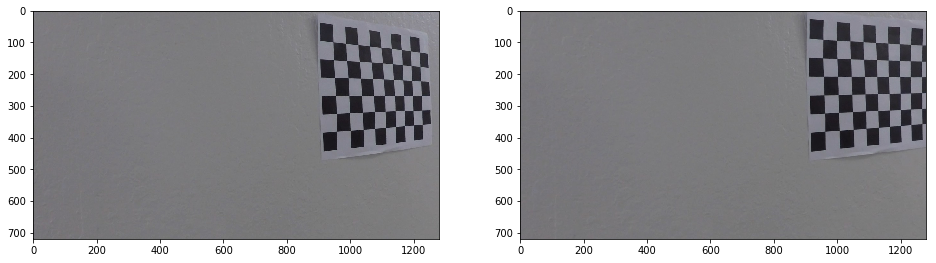

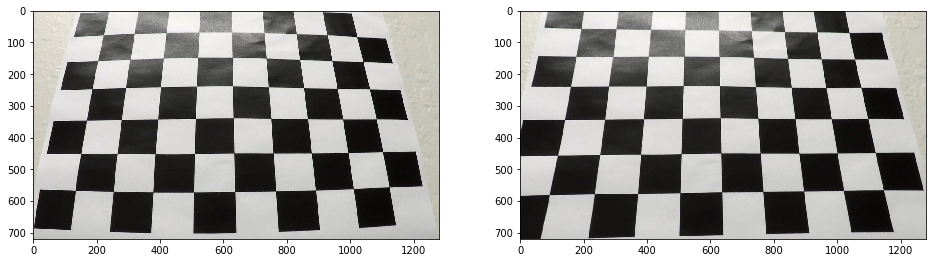

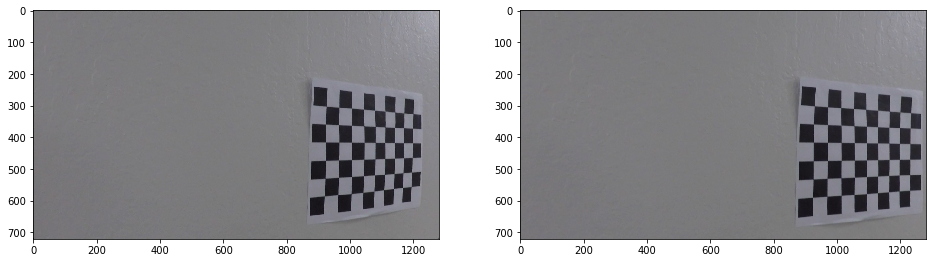

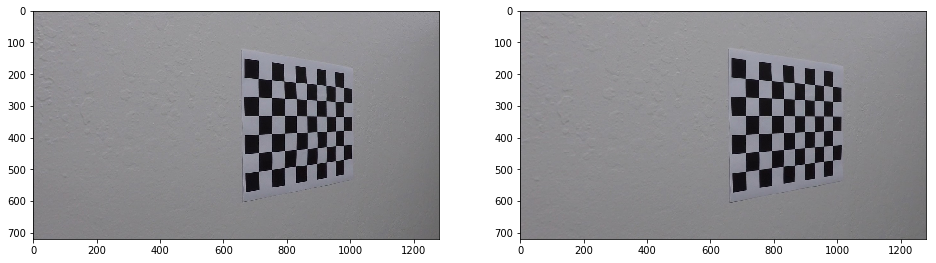

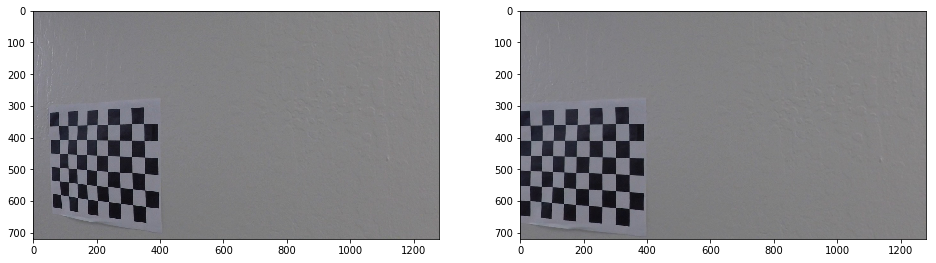

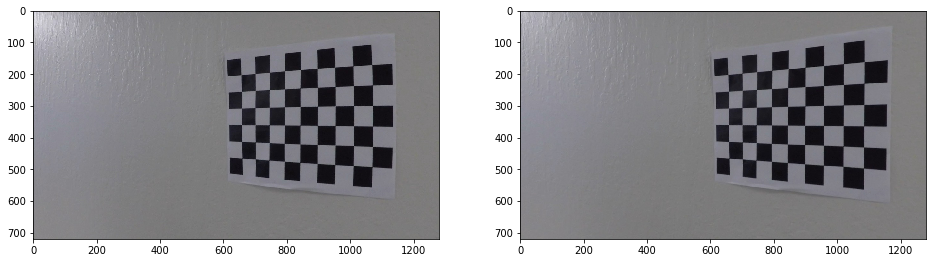

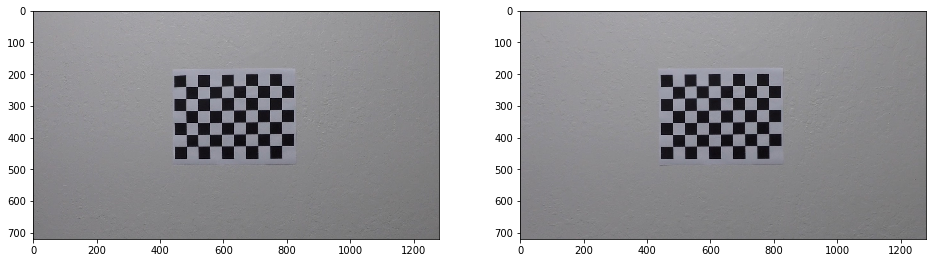

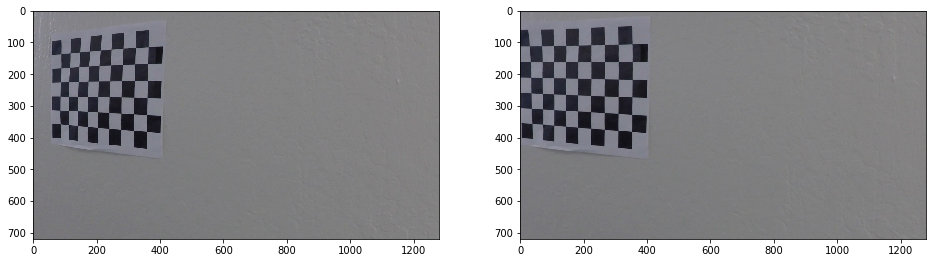

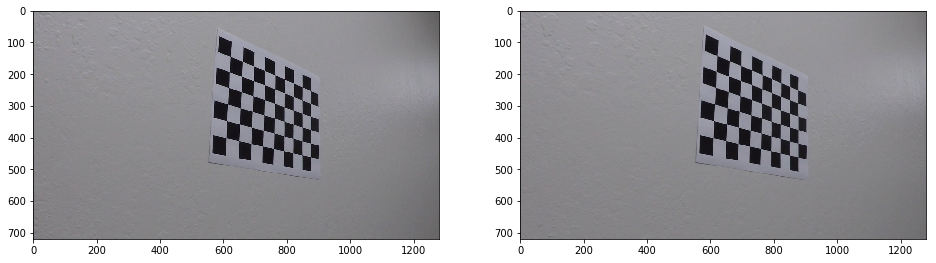

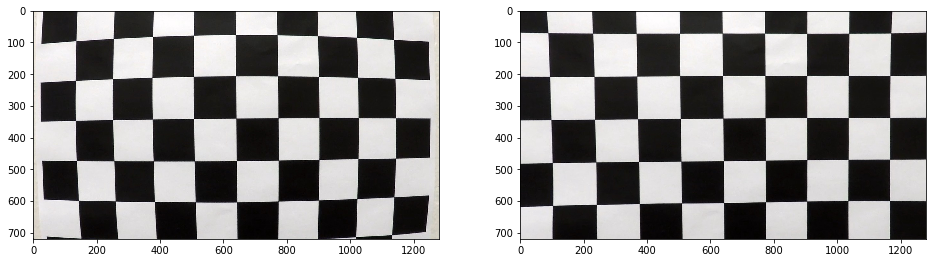

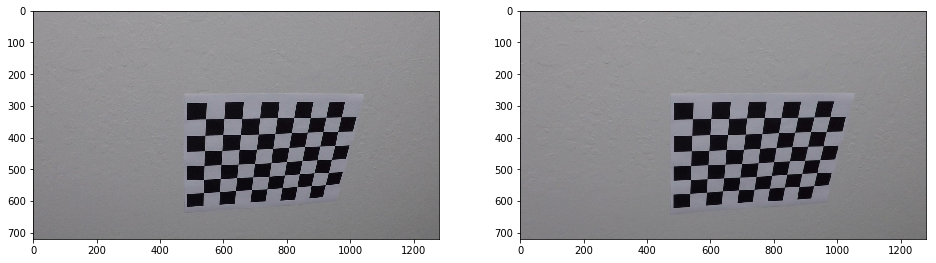

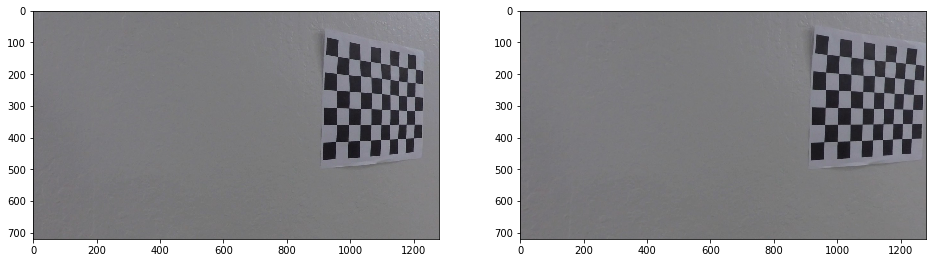

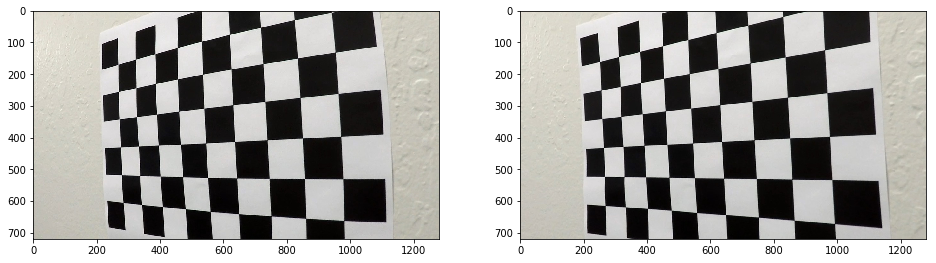

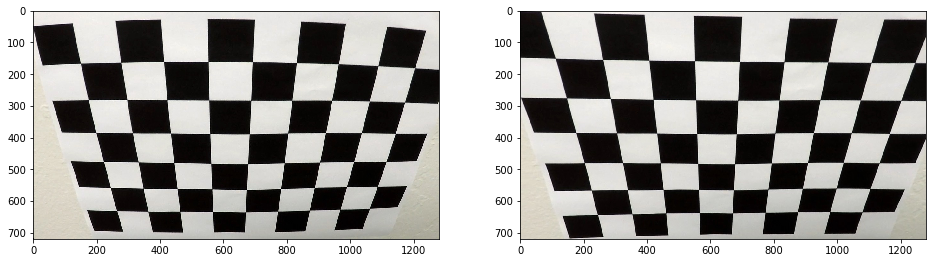

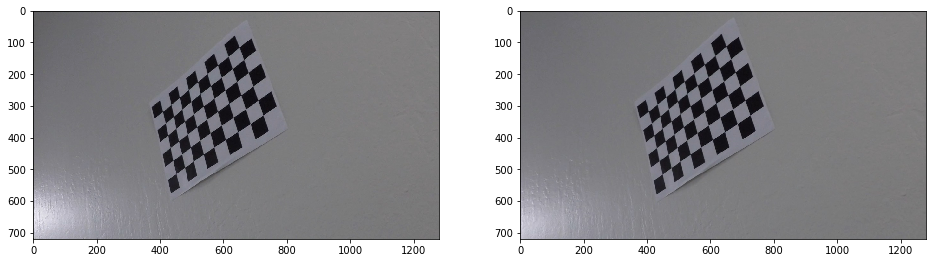

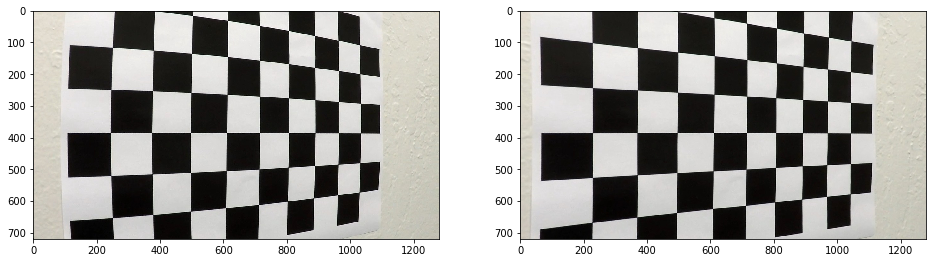

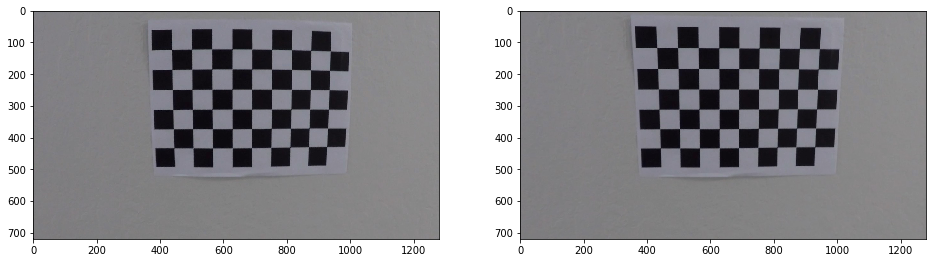

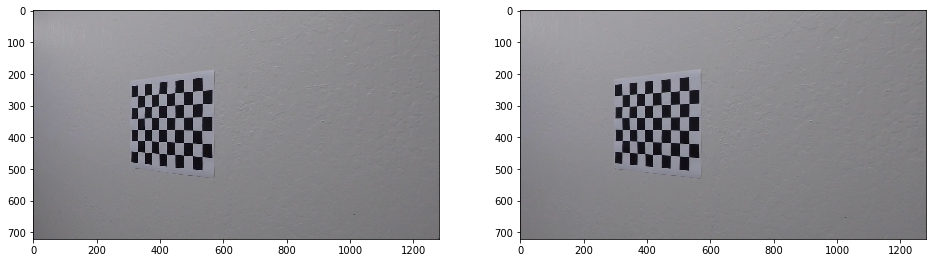

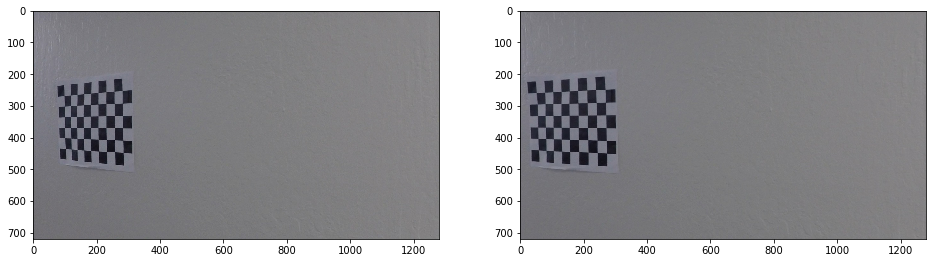

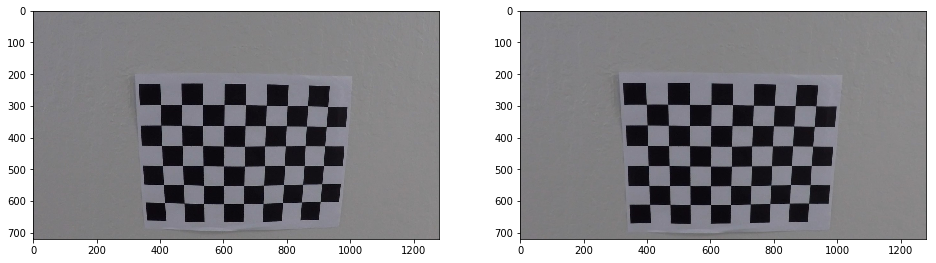

TypeError: 'module' object is not callable

In [3]:
# Calibrate the Camera

# Calculate the camera matrix
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

# Make figures bigger
plt.rcParams['figure.figsize'] = [16, 8]

# Undistort
for fnames in images:
    img = mpimg.imread(fnames)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Subplots
    plt.figure()
    plt.subplot(121)
    plt.imshow(img)
    plt.subplot(122)
    plt.imshow(dst)
    plt.show()

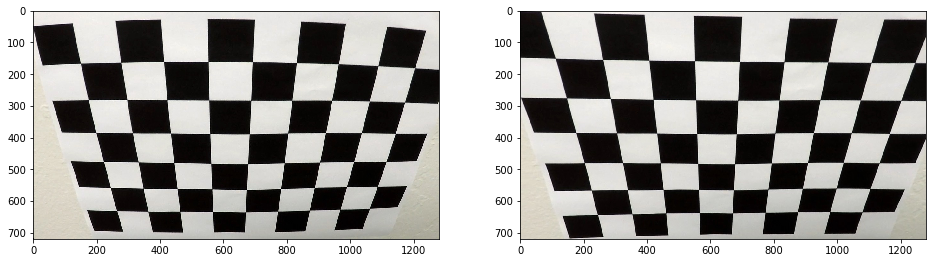

In [4]:
# Saves image for write up
img = mpimg.imread('camera_cal/calibration2.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.figure()
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(dst)
plt.savefig('output_images/calibration_result.jpg')

# 2.) Color transformation

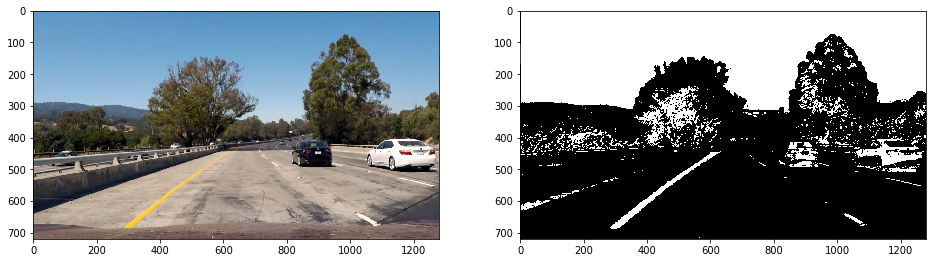

In [4]:
# Applying HLS and color filters

image = mpimg.imread('test_images/test1.jpg')

def hls_select(img, thresh_low, thresh_high):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh_low) & (S <= thresh_high)] = 1
    
    return binary_output


hls_binary = hls_select(image, 90, 255) # (90, 255)

# Plotting results
plt.rcParams['figure.figsize'] = [16, 8]
plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(hls_binary, cmap='gray')

# Gradient filter

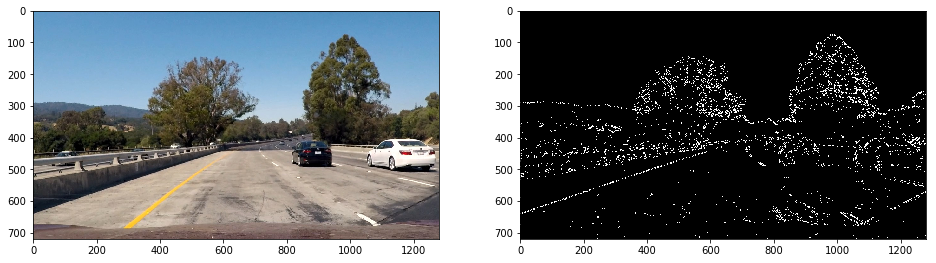

In [5]:
# Using the gradient filters to extract the desired image

def abs_sobel_thresh(img, orient, ksize, thresh_min=0, thresh_max=255):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize)
        
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0,255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    scaled_sobel = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output


# Combine the sobel filter outputs

image = mpimg.imread('test_images/test1.jpg')

ksize = 5

# Calculates each filters
gradx = abs_sobel_thresh(image, 'x', ksize, 20, 100)
grady = abs_sobel_thresh(image, 'y', ksize, 20, 100)
mag_binary = mag_thresh(image, ksize, (30, 100))
dir_binary = dir_threshold(image, ksize, (0.7, 1.3))

# Combine here
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plotting results
plt.rcParams['figure.figsize'] = [16, 8]
plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(combined, cmap='gray')

# Combining Color and Gradient Threshold

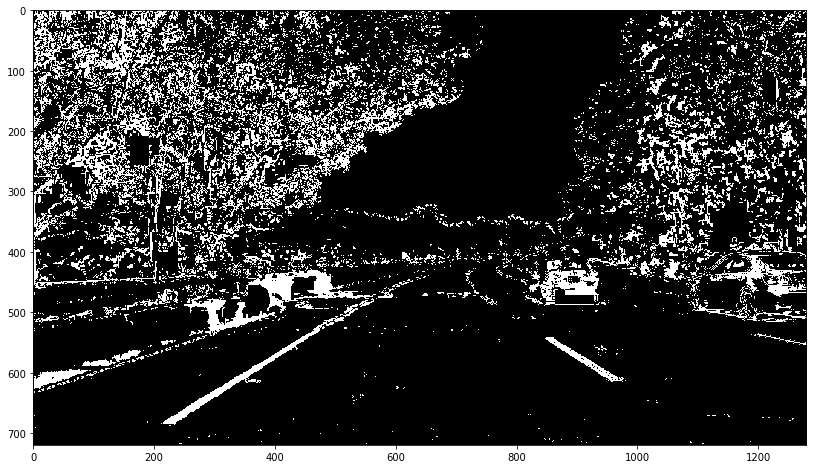

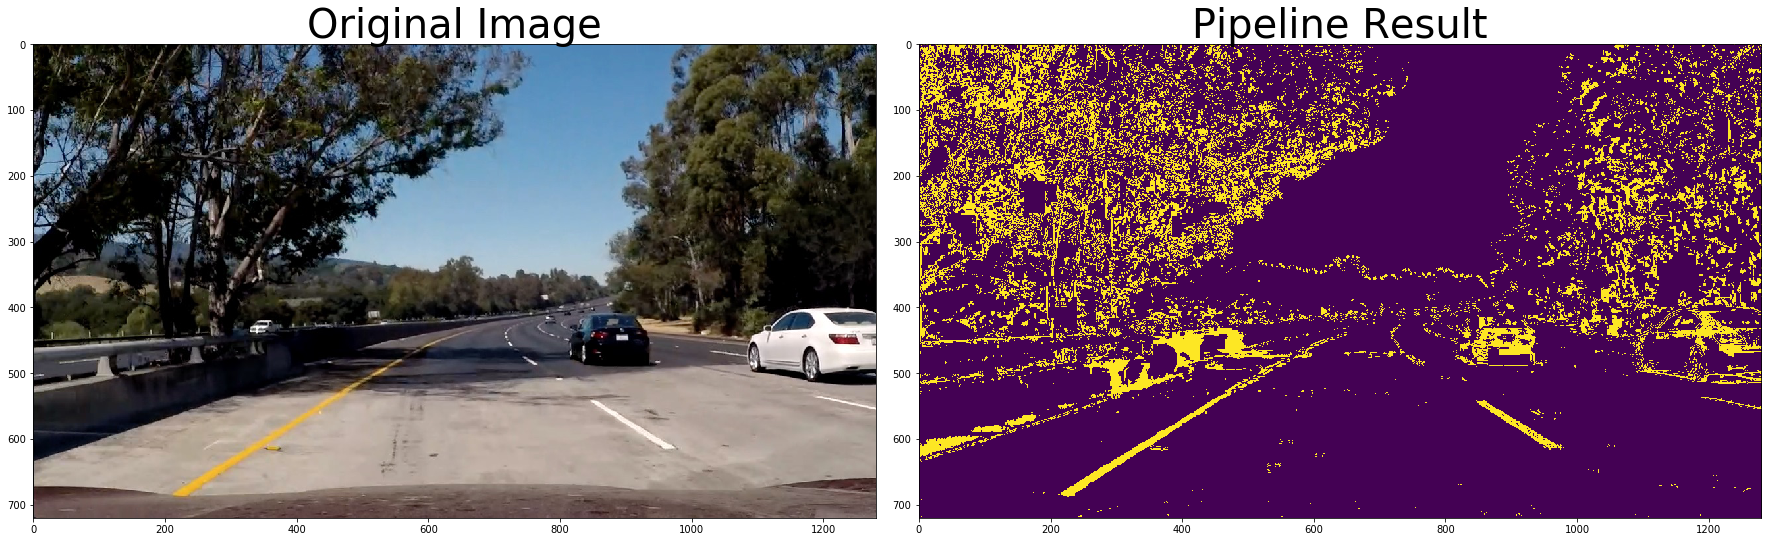

In [6]:
# Combine the two threhold methods here

# Edit this function to create your own pipeline.

def pipeline(img, color_thresh=(170, 255), grad_thresh=(20, 100), m_thresh=(30,100), dir_thresh=(0.7, 1.3)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Gradient threshold
    ksize = 5

    # Calculates each filters
    gradx = abs_sobel_thresh(img, 'x', ksize, grad_thresh[0], grad_thresh[1])
    grady = abs_sobel_thresh(img, 'y', ksize, grad_thresh[0], grad_thresh[1])
    mag_binary = mag_thresh(img, ksize, m_thresh)
    dir_binary = dir_threshold(img, ksize, dir_thresh)

    # Combine here
    grad_combined = np.zeros_like(dir_binary)
    grad_combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # Threshold color channel
    color_binary = np.zeros_like(s_channel)
    color_binary[(s_channel >= color_thresh[0]) & (s_channel <= color_thresh[1])] = 1
    
    # Stack each channel
    
    # Use this for Visual purpose!
    #combined_binary = np.dstack((np.zeros_like(color_binary), color_binary, grad_combined))
    
    # Use this for actual plotting!
    combined_binary = np.zeros_like(grad_combined)
    combined_binary[(grad_combined==1) | (color_binary==1)] = 1
    
    return combined_binary

image = mpimg.imread('test_images/test5.jpg')

result = pipeline(image, color_thresh=(150, 255), grad_thresh=(30, 100), m_thresh=(30,100), dir_thresh=(0.7, 1.3))

plt.figure()
plt.imshow(result, cmap='gray')

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Perspective Transform

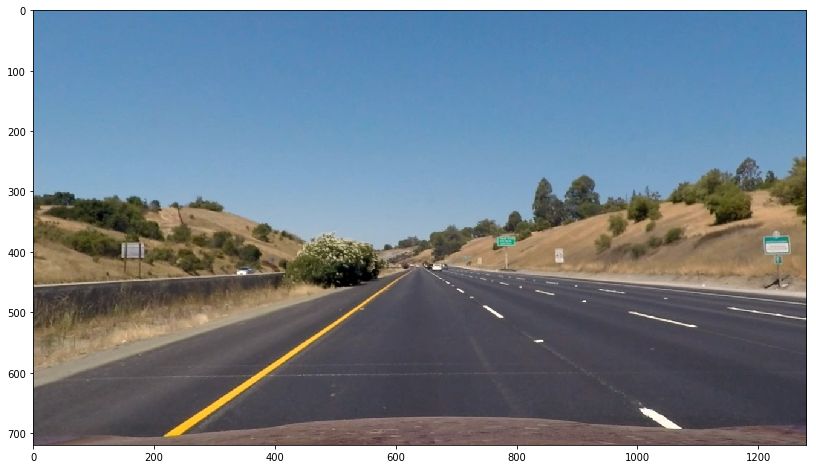

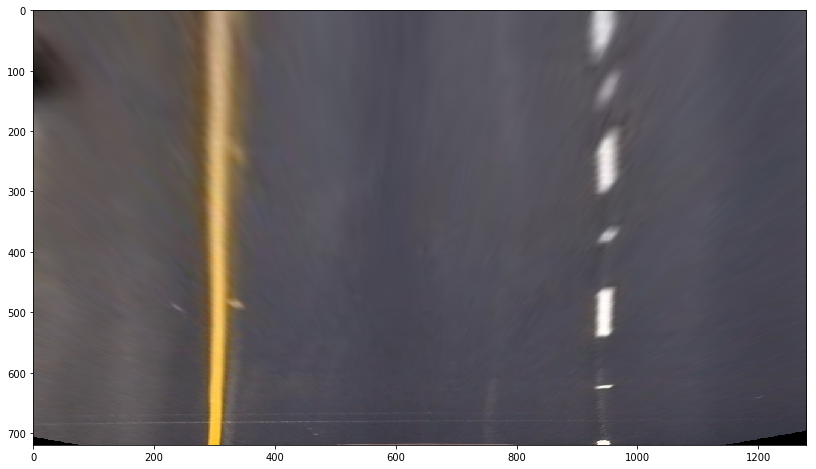

In [50]:
# Prepare a perspective transform

img = mpimg.imread('test_images/straight_lines1.jpg')

# First undistort the target image

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
undist = cv2.undistort(img, mtx, dist, None, mtx)

# Create the polygon for plot, identify the src to dest points
src1 = [265,680]
src2 = [595,450]
src3 = [685,450]
src4 = [1050, 680]
src_pt = np.array([[src1,src2,src3,src4]],np.float32)

dst1 = [300, undist.shape[0]]
dst2 = [300, 0]
dst3 = [950,0]
dst4 = [950, undist.shape[0]]
dst_pt = np.array([[dst1,dst2,dst3,dst4]],np.float32)

# Plots the line for view
#src_pt = np.int32([[0,0],[0,0],[0,0],[0,0]])
#cv2.polylines(undist,[src_pt],True,(255,0,0),thickness=1)

plt.figure()
plt.imshow(undist)

# Perform perspective transform
M = cv2.getPerspectiveTransform(src_pt, dst_pt)
_,udis_shape1,udis_shape2 = undist.shape[::-1]
warped = cv2.warpPerspective(undist, M, (udis_shape1,udis_shape2), flags=cv2.INTER_LINEAR)

plt.figure()
plt.imshow(warped)

def perspective_transform(undist):
    src1 = [265,680]
    src2 = [595,450]
    src3 = [685,450]
    src4 = [1050, 680]
    src_pt = np.array([[src1,src2,src3,src4]],np.float32)

    dst1 = [300, undist.shape[0]]
    dst2 = [300, 0]
    dst3 = [950,0]
    dst4 = [950, undist.shape[0]]
    dst_pt = np.array([[dst1,dst2,dst3,dst4]],np.float32)
    
    if(len(undist.shape)==3):
        M = cv2.getPerspectiveTransform(src_pt, dst_pt)
        _,udis_shape1,udis_shape2 = undist.shape[::-1]
        warped = cv2.warpPerspective(undist, M, (udis_shape1,udis_shape2), flags=cv2.INTER_LINEAR)
    else:
        M = cv2.getPerspectiveTransform(src_pt, dst_pt)
        udis_shape1,udis_shape2 = undist.shape[::-1]
        warped = cv2.warpPerspective(undist, M, (udis_shape1,udis_shape2), flags=cv2.INTER_LINEAR)
    
    return warped

def inverse_perspective_transform(undist):
    
    # Simply swaps the source and destination
    src1 = [265,680]
    src2 = [595,450]
    src3 = [685,450]
    src4 = [1050, 680]
    dst_pt = np.array([[src1,src2,src3,src4]],np.float32)

    dst1 = [300, undist.shape[0]]
    dst2 = [300, 0]
    dst3 = [950,0]
    dst4 = [950, undist.shape[0]]
    src_pt = np.array([[dst1,dst2,dst3,dst4]],np.float32)
    
    if(len(undist.shape)==3):
        M = cv2.getPerspectiveTransform(src_pt, dst_pt)
        _,udis_shape1,udis_shape2 = undist.shape[::-1]
        warped = cv2.warpPerspective(undist, M, (udis_shape1,udis_shape2), flags=cv2.INTER_LINEAR)
    else:
        M = cv2.getPerspectiveTransform(src_pt, dst_pt)
        udis_shape1,udis_shape2 = undist.shape[::-1]
        warped = cv2.warpPerspective(undist, M, (udis_shape1,udis_shape2), flags=cv2.INTER_LINEAR)
    
    return warped

    

    

# Filter, perspective transform, finding lanes

Curvatures_l_r 397.350500398 295.534985572
667.0 0.27


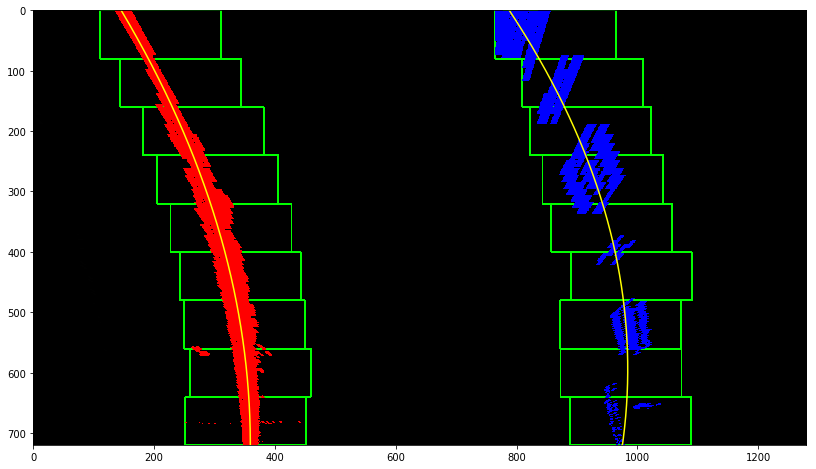

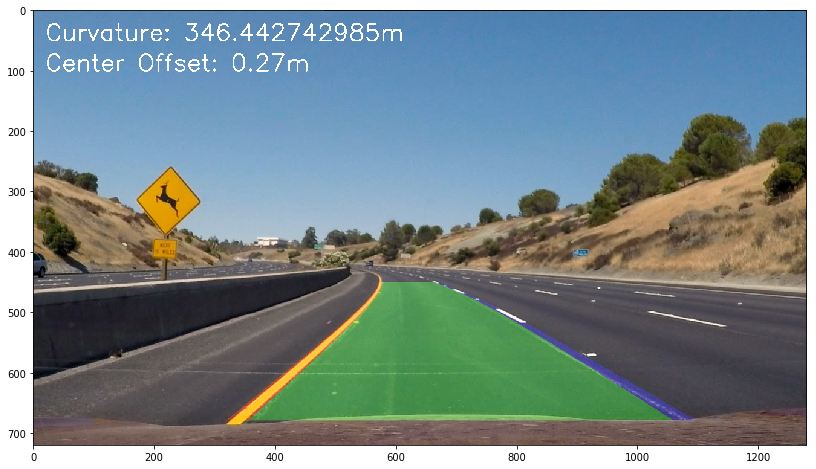

In [139]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2


# Definition of finding lanes and curved lines made here
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    # Offset to exclude clearly out of bound beginnings
    leftx_base = np.argmax(histogram[130:midpoint]) + 130
    rightx_base = np.argmax(histogram[midpoint:-130]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    # modified to output the polynominals needed
    return out_img, left_fitx, right_fitx, ploty

#  Definition for calculating the curvatures
def measure_curvature_real(ploty, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Swapped with real data
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fit_cr*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fit_cr*xm_per_pix, 2)
    
    left_fit = left_fit_cr
    right_fit = right_fit_cr
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    y_eval = y_eval*ym_per_pix
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = (1+(2*left_fit[0]*y_eval+left_fit[1])**2)**(3/2)/np.abs(2*left_fit[0])  ## Implement the calculation of the left line here
    right_curverad = (1+(2*right_fit[0]*y_eval+right_fit[1])**2)**(3/2)/np.abs(2*right_fit[0])  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad


# Load our image, undistort, get binary then warp it
image = mpimg.imread('test_images/test2.jpg')
undist = cv2.undistort(image, mtx, dist, None, mtx)
binary = pipeline(undist, color_thresh=(150, 255), grad_thresh=(30, 100), m_thresh=(30,100), dir_thresh=(0.7, 1.3))
warped = perspective_transform(binary)

# Find and show the lines found
out_img, left_x, right_x, ploty = fit_polynomial(warped)
plt.imshow(out_img/255)
#plt.imshow(warped, cmap='gray')

# Plot polynomial to be warped back to the original image
# Create blank image
blank_img = np.zeros_like(image)

# Creaets polynomial points for plot and format to be compliant
left_pts = np.array(list(zip(left_x, ploty))).astype(int)
right_pts = np.array(list(zip(right_x, ploty))).astype(int)
both_pts = np.concatenate((left_pts, np.flipud(right_pts)))

# Plots poly line and fills it
cv2.fillPoly(blank_img,[both_pts],(0,255,0))
cv2.polylines(blank_img,[left_pts],False,(255,0,0),30)
cv2.polylines(blank_img,[right_pts],False,(0,0,255),30)

# Calculate the curvatures
left_curverad, right_curverad = measure_curvature_real(ploty, left_x, right_x)
print('Curvatures_l_r', left_curverad, right_curverad)

# Calculate the distance from center
left_start = left_pts[-1][0]
right_start = right_pts[-1][0]
center_start = (left_start + right_start) / 2
center_offset = (center_start - image.shape[1]/2)/100
print(center_start, center_offset)

# Warps the lines to original image and interpolates, writes in curvature
warp_back = inverse_perspective_transform(blank_img)
interpolated_img = cv2.addWeighted(image, 1, warp_back, 0.3, 0)
interpolated_img = cv2.putText(interpolated_img,
                               'Curvature: '+str((left_curverad+right_curverad)/2) + 'm',
                               (20,50), cv2.FONT_HERSHEY_SIMPLEX, 1.3,(255,255,255) ,2)
interpolated_img = cv2.putText(interpolated_img,
                               'Center Offset: '+str(center_offset) + 'm',
                               (20,100), cv2.FONT_HERSHEY_SIMPLEX, 1.3,(255,255,255) ,2)


plt.figure()
plt.imshow(interpolated_img)

# Putting it all together

In [140]:
# Turning off visual output for pipeline
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    # Offset to exclude clearly out of bound beginnings
    leftx_base = np.argmax(histogram[130:midpoint]) + 130
    rightx_base = np.argmax(histogram[midpoint:-130]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    # modified to output the polynominals needed
    return out_img, left_fitx, right_fitx, ploty

In [141]:
# The final pipeline to put it all together

def process_image(image):
    
    # The image is taken from the mp4 and loaded
    # The image is undistorted, filtered, then perspective transformed
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    binary = pipeline(undist, color_thresh=(150, 255), grad_thresh=(30, 100), m_thresh=(30,100), dir_thresh=(0.7, 1.3))
    warped = perspective_transform(binary)

    # Find the lines and polynomial values
    out_img, left_x, right_x, ploty = fit_polynomial(warped)

    # Draw polynomial to be warped back to the original image
    # Create blank image
    blank_img = np.zeros_like(image)

    # Creaets polynomial points for plot and format to be compliant
    left_pts = np.array(list(zip(left_x, ploty))).astype(int)
    right_pts = np.array(list(zip(right_x, ploty))).astype(int)
    both_pts = np.concatenate((left_pts, np.flipud(right_pts)))

    # Plots poly line and fills it
    cv2.fillPoly(blank_img,[both_pts],(0,255,0))
    cv2.polylines(blank_img,[left_pts],False,(255,0,0),30)
    cv2.polylines(blank_img,[right_pts],False,(0,0,255),30)

    # Calculate the curvatures
    left_curverad, right_curverad = measure_curvature_real(ploty, left_x, right_x)

    # Calculate the distance from center
    left_start = left_pts[-1][0]
    right_start = right_pts[-1][0]
    center_start = (left_start + right_start) / 2
    center_offset = (center_start - image.shape[1]/2)/100
    
    # Warps the lines to original image and interpolates, writes in curvature
    warp_back = inverse_perspective_transform(blank_img)
    interpolated_img = cv2.addWeighted(image, 1, warp_back, 0.3, 0)
    interpolated_img = cv2.putText(interpolated_img,
                                   'Curvature: '+str((left_curverad+right_curverad)/2) + 'm',
                                   (20,50), cv2.FONT_HERSHEY_SIMPLEX, 1.3,(255,255,255) ,2)
    interpolated_img = cv2.putText(interpolated_img,
                                   'Center Offset: '+str(center_offset) + 'm',
                                   (20,100), cv2.FONT_HERSHEY_SIMPLEX, 1.3,(255,255,255) ,2)

    
    return interpolated_img

In [142]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [143]:
white_output = 'project_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [08:17<00:00,  2.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 5min 58s, sys: 2.71 s, total: 6min 1s
Wall time: 8min 20s


In [150]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_video_out.mp4'))

In [108]:
challenge_output = 'challenge_video_out.mp4'
clip2 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video challenge_video_out.mp4
[MoviePy] Writing video challenge_video_out.mp4


100%|██████████| 485/485 [03:07<00:00,  2.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_out.mp4 

CPU times: user 2min 17s, sys: 1.15 s, total: 2min 18s
Wall time: 3min 10s


In [109]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))